In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.hp_tuning_functions import *
from src.plot_functions import *

In [2]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters

In [3]:
from tsfresh.utilities.dataframe_functions import roll_time_series

# Load data

In [4]:
ts = load_data(SOURCES)

In [5]:
# ts = encode_static_covariates(ts, ordinal=False)

<Axes: xlabel='date'>

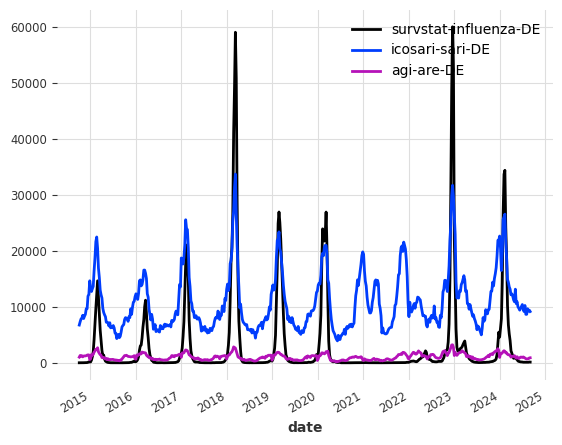

In [6]:
ts['survstat-influenza-DE'].plot()
ts['icosari-sari-DE'].plot()
ts['agi-are-DE'].plot()

In [7]:
df = ts.pd_dataframe()

In [8]:
df_melted = ts[[c for c in ts.columns if 'icosari' in c]].pd_dataframe().reset_index().melt(id_vars='date')

In [9]:
df_melted.head()

,date,component,value
0,2014-10-05,icosari-sari-DE,6734.0
1,2014-10-12,icosari-sari-DE,7316.0
2,2014-10-19,icosari-sari-DE,7815.0
3,2014-10-26,icosari-sari-DE,7981.0
4,2014-11-02,icosari-sari-DE,8480.0


In [10]:
df_rolled = roll_time_series(df_melted, column_id="component", column_sort="date", min_timeshift=8, max_timeshift=8)

Rolling: 100%|██████████| 104/104 [00:00<00:00, 171.85it/s]


In [11]:
df_rolled = df_rolled.drop(columns='component')

In [12]:
df_features = extract_features(df_rolled, column_id="id", column_sort="date")

Feature Extraction: 100%|██████████| 119/119 [00:17<00:00,  6.95it/s]


In [13]:
df_features

value__variance_larger_than_standard_deviation  \
icosari-sari-00-04 2014-11-30                                             1.0   
                   2014-12-07                                             1.0   
                   2014-12-14                                             1.0   
                   2014-12-21                                             1.0   
                   2014-12-28                                             1.0   
...                                                                       ...   
icosari-sari-DE    2024-08-04                                             1.0   
                   2024-08-11                                             1.0   
                   2024-08-18                                             1.0   
                   2024-08-25                                             1.0   
                   2024-09-01                                             1.0   

                               value__has_duplicate_max  \
icosari-sari-00-04 2014-11-30                       0.0   
                   2014-12-07                       0.0   
                   2014-12-14                       0.0   
                   2014-12-21                       0.0   
                   2014-12-28                       0.0   
...                                                 ...   
icosari-sari-DE    2024-08-04                       0.0   
                   2024-08-11                       0.0   
                   2024-08-18                       0.0   
                   2024-08-25                       0.0   
                   2024-09-01                       0.0   

                               value__has_duplicate_min  value__has_duplicate  \
icosari-sari-00-04 2014-11-30                       0.0                   0.0   
                   2014-12-07                       0.0                   0.0   
                   2014-12-14                       0.0                   0.0   
                   2014-12-21                       0.0                   0.0   
                   2014-12-28                       0.0                   0.0   
...                                                 ...                   ...   
icosari-sari-DE    2024-08-04                       1.0                   1.0   
                   2024-08-11                       1.0                   1.0   
                   2024-08-18                       1.0                   1.0   
                   2024-08-25                       1.0                   1.0   
                   2024-09-01                       1.0                   1.0   

                               value__sum_values  value__abs_energy  \
icosari-sari-00-04 2014-11-30            15232.0         27050592.0   
                   2014-12-07            16442.0         31757492.0   
                   2014-12-14            18783.0         42809353.0   
                   2014-12-21            20934.0         54254824.0   
                   2014-12-28            24125.0         75159065.0   
...                                          ...                ...   
icosari-sari-DE    2024-08-04            85795.0        821141243.0   
                   2024-08-11            86045.0        825900743.0   
                   2024-08-18            85546.0        816442198.0   
                   2024-08-25            84881.0        803505953.0   
                   2024-09-01            83634.0        779143314.0   

                               value__mean_abs_change  value__mean_change  \
icosari-sari-00-04 2014-11-30                 282.625             141.375   
                   2014-12-07                 273.750             170.000   
                   2014-12-14                 347.000             243.250   
                   2014-12-21                 360.750             257.000   
                   2014-12-28                 481.375             420.125   
...                                               ...        

In [14]:
# drop columns that contain only one value
unique_cols = df_features.nunique()[df_features.nunique() == 1].index.tolist()
df_features = df_features.drop(columns=unique_cols)

In [15]:
df_features.shape

(3570, 726)

In [16]:
df_features = df_features.dropna(axis=1)

In [17]:
df_features.shape

(3570, 262)

In [18]:
# impute(df_features)

In [19]:
feature_list = []
for horizon in [1, 2, 3, 4]:
    y = df_melted.groupby("component").apply(lambda x: x.set_index("date")["value"].shift(-horizon)).T.unstack()
    y = y[y.index.isin(df_features.index)]
    y = y.dropna()
    df_features_temp = df_features[df_features.index.isin(y.index)]
    features_filtered = select_features(df_features_temp, y)
    feature_list += list(features_filtered.columns)
feature_list = list(set(feature_list))

/tmp/ipykernel_202169/1149516672.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_202169/1149516672.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_202169/1149516672.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either 

In [20]:
len(feature_list)

237

In [21]:
features_filtered = df_features[feature_list]

In [22]:
features_filtered

value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4  \
icosari-sari-00-04 2014-11-30                                               95.0                    
                   2014-12-07                                                0.0                    
                   2014-12-14                                              320.0                    
                   2014-12-21                                              199.5                    
                   2014-12-28                                              530.0                    
...                                                                          ...                    
icosari-sari-DE    2024-08-04                                              332.0                    
                   2024-08-11                                              332.0                    
                   2024-08-18                                                0.0                    
                   2024-08-25                                                0.0                    
                   2024-09-01                                              166.0                    

                               value__fft_coefficient__attr_"angle"__coeff_4  \
icosari-sari-00-04 2014-11-30                                    -130.756862   
                   2014-12-07                                     141.335325   
                   2014-12-14                                    -178.496669   
                   2014-12-21                                     154.573230   
                   2014-12-28                                     164.148444   
...                                                                      ...   
icosari-sari-DE    2024-08-04                                     126.889037   
                   2024-08-11                                     -86.280671   
                   2024-08-18                                      43.215912   
                   2024-08-25                                    -114.251482   
                   2024-09-01                                       1.953072   

                               value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"  \
icosari-sari-00-04 2014-11-30                                             1461.0                      
                   2014-12-07                                             1548.0                      
                   2014-12-14                                             1616.0                      
                   2014-12-21                                             1729.2                      
                   2014-12-28                                             1887.4                      
...                                                                          ...                      
icosari-sari-DE    2024-08-04                                             9826.4                      
                   2024-08-11                                             9776.6                      
                   2024-08-18                                             9876.4                      
                   2024-08-25                                             9593.8                      
                   2024-09-01                                             9244.6                      

                               value__energy_ratio_by_chunks__num_segments_10__segment_focus_6  \
icosari-sari-00-04 2014-11-30                                           0.086538                 
                   2014-12-07                                           0.145692                 
                   2014-12-14                                           0.142629                 
                   2014-12-21                                           0.119851                 
                   2014-12-28                                           0.165888                 
...                             

In [23]:
features_filtered = features_filtered.reset_index(names=['component', 'date'])

In [24]:
features_filtered.to_csv('../data/features/features_icosari_8w.csv', index=False)

In [27]:
def combine_component_and_feature_names(ts):
    return ts.with_columns_renamed(ts.columns, ts.static_covariates.component.unique() + '__' + ts.columns)

In [28]:
def load_features(lag=8):
    df_features = pd.read_csv(f'../data/features/features_icosari_{lag}w.csv')
    ts_features = TimeSeries.from_group_dataframe(df_features, group_cols=['component'], 
                                                  time_col='date', freq='7D', fillna_value=0)
    ts_features = [combine_component_and_feature_names(ts_age) for ts_age in ts_features]
    ts_features = [ts_age.with_static_covariates(None) for ts_age in ts_features]
    return concatenate(ts_features, axis='component')

In [4]:
ts_features = load_features()

In [5]:
ts_features = load_features(multiple_series=True)

In [8]:
len(ts_features)

7

In [10]:
list(ts_features[0].columns)

['icosari-sari-00-04__value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4',
 'icosari-sari-00-04__value__fft_coefficient__attr_"angle"__coeff_4',
 'icosari-sari-00-04__value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"',
 'icosari-sari-00-04__value__energy_ratio_by_chunks__num_segments_10__segment_focus_6',
 'icosari-sari-00-04__value__large_standard_deviation__r_0.30000000000000004',
 'icosari-sari-00-04__value__percentage_of_reoccurring_datapoints_to_all_datapoints',
 'icosari-sari-00-04__value__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"',
 'icosari-sari-00-04__value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0',
 'icosari-sari-00-04__value__energy_ratio_by_chunks__num_segments_10__segment_focus_1',
 'icosari-sari-00-04__value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0',
 'icosari-sari-00-04__value__sum_of_reoccurring_values',
 'icosari-sari-00-04__value__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 

<Axes: xlabel='date'>

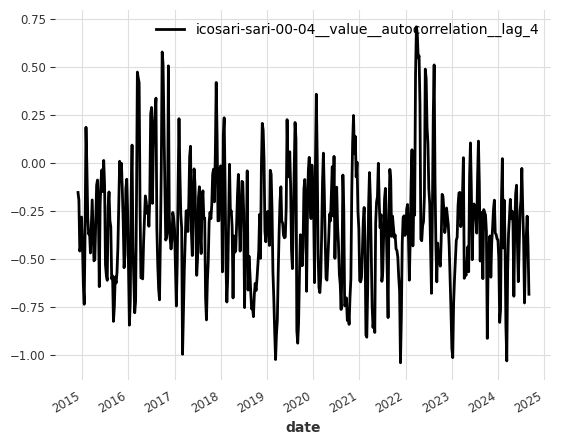

In [13]:
ts_features[0]['icosari-sari-00-04__value__autocorrelation__lag_4'].plot()

Number of components is larger than 10 (1659). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


<Axes: xlabel='date'>

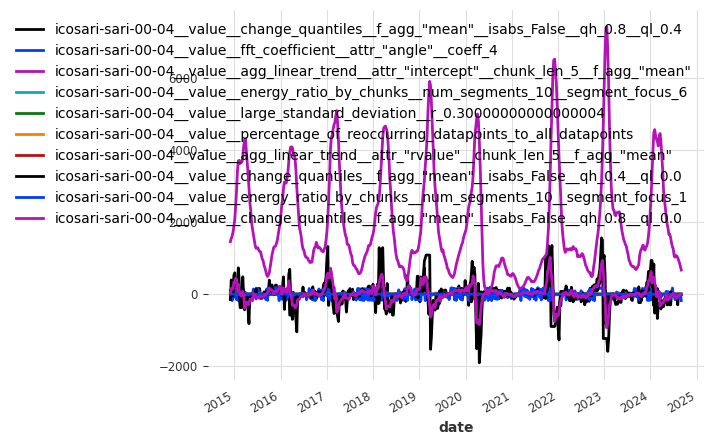

In [30]:
ts_features.plot()

In [33]:
TARGETS

['icosari-sari-DE',
 'icosari-sari-00-04',
 'icosari-sari-05-14',
 'icosari-sari-15-34',
 'icosari-sari-35-59',
 'icosari-sari-60-79',
 'icosari-sari-80+']

In [36]:
ts_features[[col for col in ts_features.columns if TARGETS[0] in col]]

<TimeSeries (DataArray) (date: 510, component: 237, sample: 1)>
array([[[ 4.99000000e+02],
        [ 1.49371697e+02],
        [ 7.66520000e+03],
        ...,
        [ 4.98833333e+02],
        [ 4.99000000e+02],
        [ 1.08144934e+04]],

       [[ 3.33000000e+02],
        [-1.52077592e+02],
        [ 7.89800000e+03],
        ...,
        [ 4.71166667e+02],
        [ 3.33000000e+02],
        [ 1.11453156e+04]],

       [[ 4.99000000e+02],
        [ 1.47651091e+02],
        [ 8.09740000e+03],
        ...,
...
        ...,
        [ 6.15400000e+02],
        [ 0.00000000e+00],
        [ 1.16057826e+04]],

       [[ 0.00000000e+00],
        [-1.14251482e+02],
        [ 9.59380000e+03],
        ...,
        [ 5.82000000e+02],
        [ 0.00000000e+00],
        [ 1.14604629e+04]],

       [[ 1.66000000e+02],
        [ 1.95307202e+00],
        [ 9.24460000e+03],
        ...,
        [ 4.65400000e+02],
        [ 1.66000000e+02],
        [ 1.15677818e+04]]])
Coordinates:
  * date       (date) datetime64[ns] 2014-11-30 2014-12-07 ... 2024-09-01
  * component  (component) object 'icosari-sari-DE__value__change_quantiles__...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Remove highly correlated features

In [40]:
import numpy as np

In [38]:
corr_matrix = features_filtered.iloc[:, 2:].corr().abs()

In [52]:
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

In [57]:
threshold = 0.9  # Set your threshold for high correlation
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

In [58]:
features_filtered.shape

(3570, 239)

In [59]:
len(to_drop)

106

In [ ]:
[f for f in features_filtered.columns if f not in to_drop]